# Imports

In [1]:
!pip install transformers

import os
import random
import time

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from transformers import XLMRobertaModel, XLMRobertaTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Set global variables

In [2]:
SEED = 42
MAX_LENGTH = 100
DEVICE = "cuda"

CHECKPOINT_PATH = 'best_model.dat'
DATA_PATH =  "jigsaw"
TRAIN_FILE = "jigsaw-toxic-comment-train.csv"
VALID_FILE = "validation.csv"
TEST_FILE = "test.csv"
SAMPLE_SUBMISSION_FILE = "sample_submission.csv"
SUBMISSION_FILE = "submission.csv"

SENTENCE_LABEL = 'comment_text'
TARGET_LABEL = 'toxic'
TEST_LABEL = 'content'

# Fix seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Examples

Load and look at examples from [our first competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/). These are comments from Wikipedia with a variety of annotations (toxic, obscene, threat, etc).

In [4]:
# train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE))
# valid = pd.read_csv(os.path.join(DATA_PATH, VALID_FILE))
# train.head()

# Dataset Loader

In [5]:
class ToxicDataset(Dataset):

    def __init__(self, filename, maxlen, tokenizer_cls, tokenizer_name):
        self.df = pd.read_csv(filename)
        self.tokenizer = tokenizer_cls.from_pretrained(tokenizer_name)
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, SENTENCE_LABEL]
        label = self.df.loc[index, TARGET_LABEL]
        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        tokens = ['[CLS]'] + tokens + ['[SEP]'] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label


class ToxicTestDataset(Dataset):

    def __init__(self, filename, maxlen, tokenizer_cls, tokenizer_name):
        self.df = pd.read_csv(filename)
        self.tokenizer = tokenizer_cls.from_pretrained(tokenizer_name)
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, TEST_LABEL]
        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        tokens = ['[CLS]'] + tokens + ['[SEP]'] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()
        return tokens_ids_tensor, attn_mask

# Model with Bert

In [6]:
class ToxicClassifier(nn.Module):

    def __init__(self, model_cls, model_name, linear_shape, freeze_bert=True):
        super().__init__()
        self.transformer_layer = model_cls.from_pretrained(model_name)

        if freeze_bert:
            for p in self.transformer_layer.parameters():
                p.requires_grad = False
        
        self.cls_layer = nn.Linear(*linear_shape)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.transformer_layer(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits


# Training

In [7]:
def tensor2numpy(tensor):
    return tensor.squeeze().cpu().detach().numpy()

def get_roc_auc_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))

    try:
      roc_auc = roc_auc_score(tensor2numpy(labels), tensor2numpy(probs))
    except:
      roc_auc = 0

    return roc_auc


def get_acc_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))

    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()

    return acc


def evaluate(net, criterion, dataloader):
    net.eval()

    mean_roc_auc = mean_acc = mean_loss = 0
    count = 0

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(seq, attn_masks)
            mean_roc_auc += get_roc_auc_from_logits(logits, labels)
            mean_acc += get_acc_from_logits(logits, labels)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            count += 1

    return (
        mean_roc_auc / count,
        mean_acc / count,
        mean_loss / count
    )


def train(net, criterion, opti, train_loader, val_loader, max_eps, print_every):
    best_roc_auc = 0

    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

            #Obtaining the logits from the model
            logits = net(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()

            if (it + 1) % print_every == 0:
                roc_auc = get_roc_auc_from_logits(logits, labels)
                acc = get_acc_from_logits(logits, labels)
                print(
                    f"Iteration {it+1} of epoch {ep+1} complete. "
                    f"Loss : {loss.item()} ROC AUC : {roc_auc} Accuracy : {acc}"
                )

        val_roc_auc, val_acc, val_loss = evaluate(net, criterion, val_loader)
        print(
            f"Epoch {ep} complete!"
            f"Validation ROC AUC : {val_roc_auc}, "
            f"Validation accuracy : {val_acc}, "
            f"Validation Loss : {val_loss}"
        )

        if val_roc_auc > best_roc_auc:
            print(
                f"Best validation ROC AUC improved from {best_roc_auc} to {val_roc_auc}, saving model..."
            )
            best_roc_auc = val_roc_auc
            torch.save(net.state_dict(), CHECKPOINT_PATH)

        yield ep, val_roc_auc, val_acc, val_loss


def predict_submit(net, test_loader):
    net.eval()

    with torch.no_grad():
        result = torch.tensor([])
        for seq, attn_masks in test_loader:
            seq, attn_masks = seq.cuda(), attn_masks.cuda()
            logits = net(seq, attn_masks)
            probs = torch.sigmoid(logits.unsqueeze(-1)).squeeze().cpu().detach()
            result = torch.cat((result, probs))

    return result


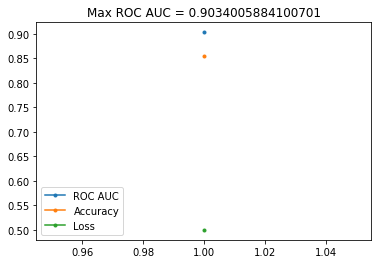

Training interrupted


In [10]:
MODEL = XLMRobertaModel
TOKENIZER = XLMRobertaTokenizer
TOKENIZER_NAME = MODEL_NAME = "xlm-roberta-large"
LINEAR_LAYER_SHAPE = (1024, 1)  # (1024, 1) for XLMRoberta; (768, 1) for Bert
BATCH_SIZE = 32
LR = 1e-5
WEIGHT_DECAY = 0.01
EPOCHS = 15
PRINT_EVERY = 100
DATALOADER_WORKERS = 5

#Creating instances of training and validation set
train_set = ToxicDataset(os.path.join(DATA_PATH, TRAIN_FILE), MAX_LENGTH, TOKENIZER, TOKENIZER_NAME)
val_set = ToxicDataset(os.path.join(DATA_PATH, VALID_FILE), MAX_LENGTH, TOKENIZER, TOKENIZER_NAME)
test_set = ToxicTestDataset(os.path.join(DATA_PATH, TEST_FILE), MAX_LENGTH, TOKENIZER, TOKENIZER_NAME)

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=DATALOADER_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=DATALOADER_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=DATALOADER_WORKERS)

net = ToxicClassifier(MODEL, MODEL_NAME, LINEAR_LAYER_SHAPE, freeze_bert=False)
net.cuda()
criterion = nn.BCEWithLogitsLoss()
opti = optim.AdamW(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

from IPython.display import clear_output
import matplotlib.pyplot as plt

epochs_plot = []
losses_plot = []
roc_aucs_plot = []
accs_plot = []

try:
  print("Started training...\n")
  for epoch_n, roc_auc, acc, loss in train(
      net, criterion, opti, train_loader, val_loader, EPOCHS, PRINT_EVERY
  ):
    clear_output()

    epochs_plot.append(epoch_n + 1)
    roc_aucs_plot.append(roc_auc)
    accs_plot.append(acc)
    losses_plot.append(loss)

    plt.plot(epochs_plot, roc_aucs_plot, marker=".", label="ROC AUC")
    plt.plot(epochs_plot, accs_plot, marker=".", label="Accuracy")
    plt.plot(epochs_plot, losses_plot, marker=".", label="Loss")
    plt.legend(loc="lower left")
    plt.title(f"Max ROC AUC = {max(roc_aucs_plot)}")
    plt.show()

except KeyboardInterrupt:
  print("Training interrupted")


In [11]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint)

checkpoint = None
del checkpoint
predicted = predict_submit(net, test_loader).numpy()
subm = pd.read_csv(os.path.join(DATA_PATH, SAMPLE_SUBMISSION_FILE))
subm['toxic'] = predicted
subm.to_csv(SUBMISSION_FILE, index = None)
print(f"Saved to {SUBMISSION_FILE}")


Saved to submission.csv
